In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [65]:
csv_files = glob.glob("data/raw/heart_rates/*.csv")
csv_files = [csv_file.replace("\\", "/") for csv_file in csv_files]

In [66]:
all_data = pd.concat(
    (pd.read_csv(file).assign(date=file.split('/')[-1].replace('.csv', '')) for file in csv_files),
    ignore_index=True
)

In [67]:
all_data.head()

,timestamp,heart_rates,date
0,14:58,69.0,2024-12-21
1,15:00,70.0,2024-12-21
2,15:02,66.0,2024-12-21
3,15:04,71.0,2024-12-21
4,15:06,75.0,2024-12-21


In [68]:
all_data.tail()

,timestamp,heart_rates,date
8842,06:36,46.0,2025-01-03
8843,06:38,57.0,2025-01-03
8844,06:40,49.0,2025-01-03
8845,06:42,50.0,2025-01-03
8846,06:44,47.0,2025-01-03


In [69]:
all_data.dtypes

timestamp       object
heart_rates    float64
date            object
dtype: object

### Calculate the Average Heart Rate Value

In [70]:
average_heart_rate_value = round(all_data['heart_rates'].mean(), 2)

print(f"Average Heart Rate Value: {average_heart_rate_value}")

Average Heart Rate Value: 64.38


### Calculate the Maximum Recorded Value and the Minimum Recorded Value of the Heart Rate

In [71]:
maximum_heart_rate_value = all_data['heart_rates'].max()
minimum_heart_rate_value = all_data['heart_rates'].min()

max_index = all_data['heart_rates'].idxmax()
min_index = all_data['heart_rates'].idxmin()

max_date = all_data.loc[max_index, 'date']
max_timestamp = all_data.loc[max_index, 'timestamp']

min_date = all_data.loc[min_index, 'date']
min_timestamp = all_data.loc[min_index, 'timestamp']

print(f"Maximum heart rate value: {maximum_heart_rate_value} recorded on {max_date} at {max_timestamp}")
print(f"Minimum heart rate value: {minimum_heart_rate_value} recorded on {min_date} at {min_timestamp}")

Maximum heart rate value: 167.0 recorded on 2024-12-22 at 15:36
Minimum heart rate value: 33.0 recorded on 2024-12-21 at 23:24


In [72]:
missing_values_counts = all_data.isna().sum()
missing_values_counts

timestamp       0
heart_rates    23
date            0
dtype: int64

In [73]:
def standardize_dataframe(df, timestamp_column):
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], format="%H:%M").dt.time

    expected_items = pd.date_range(start="00:00", end="23:58", freq="2min").time
    
    df.set_index(timestamp_column, inplace=True)
    df = df.reindex(expected_items)
    
    df.index.name = 'timestamp'
    
    return df


In [74]:
nan_counts = {}

for file_name in csv_files:
    day = file_name.split("/")[-1].replace(".csv", "")
    df = pd.read_csv(file_name)

    df = standardize_dataframe(df, timestamp_column="timestamp")

    nan_count = int(df['heart_rates'].isna().sum())
    nan_counts[day] = nan_count
    
    print(f"{day}: {nan_count} NaN values")

2024-12-21: 490 NaN values
2024-12-22: 2 NaN values
2024-12-23: 0 NaN values
2024-12-24: 0 NaN values
2024-12-25: 138 NaN values
2024-12-26: 0 NaN values
2024-12-27: 72 NaN values
2024-12-28: 17 NaN values
2024-12-29: 0 NaN values
2024-12-30: 0 NaN values
2024-12-31: 0 NaN values
2025-01-01: 20 NaN values
2025-01-02: 0 NaN values
2025-01-03: 517 NaN values


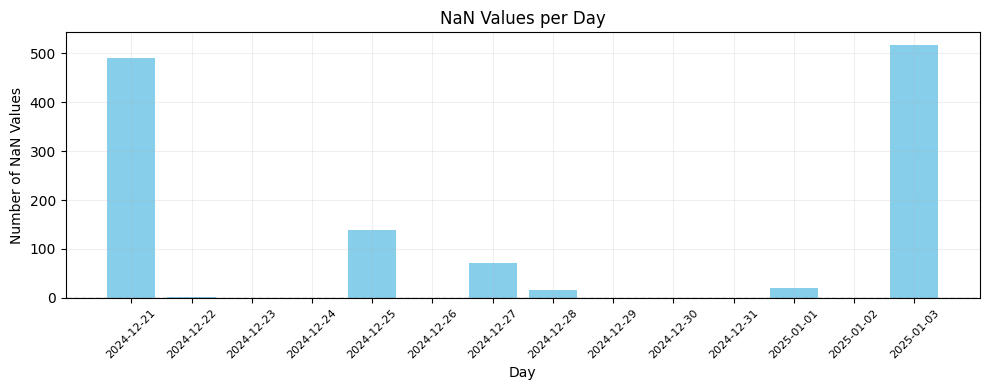

In [75]:
nan_df = pd.DataFrame(list(nan_counts.items()), columns=["Day", "NaN_Count"])

plt.figure(figsize=(10,4))
plt.bar(nan_df["Day"], nan_df["NaN_Count"], color='skyblue')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Day")
plt.ylabel("Number of NaN Values")
plt.title("NaN Values per Day")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [76]:
print(nan_counts)

{'2024-12-21': 490, '2024-12-22': 2, '2024-12-23': 0, '2024-12-24': 0, '2024-12-25': 138, '2024-12-26': 0, '2024-12-27': 72, '2024-12-28': 17, '2024-12-29': 0, '2024-12-30': 0, '2024-12-31': 0, '2025-01-01': 20, '2025-01-02': 0, '2025-01-03': 517}


In [77]:
threshold = 700

for day, value in nan_counts.items():
    valid_count = 720 - value

    if valid_count >= threshold:
        print(f"Processing day: {day} (Valid rows: {valid_count})")

        df = pd.read_csv(f"data/raw/heart_rates/{day}.csv")
        df = standardize_dataframe(df, timestamp_column="timestamp")
        
        df['heart_rates'] = df['heart_rates'].interpolate(method='linear', limit_direction='both')

        df.to_csv(f"data/processed/heart_rates/{day}_completed.csv")
        print(f"Completed interpolation for {day}")

Processing day: 2024-12-22 (Valid rows: 718)
Completed interpolation for 2024-12-22
Processing day: 2024-12-23 (Valid rows: 720)
Completed interpolation for 2024-12-23
Processing day: 2024-12-24 (Valid rows: 720)
Completed interpolation for 2024-12-24
Processing day: 2024-12-26 (Valid rows: 720)
Completed interpolation for 2024-12-26
Processing day: 2024-12-28 (Valid rows: 703)
Completed interpolation for 2024-12-28
Processing day: 2024-12-29 (Valid rows: 720)
Completed interpolation for 2024-12-29
Processing day: 2024-12-30 (Valid rows: 720)
Completed interpolation for 2024-12-30
Processing day: 2024-12-31 (Valid rows: 720)
Completed interpolation for 2024-12-31
Processing day: 2025-01-01 (Valid rows: 700)
Completed interpolation for 2025-01-01
Processing day: 2025-01-02 (Valid rows: 720)
Completed interpolation for 2025-01-02


In [78]:
csv_processed_files = glob.glob("data/processed/heart_rates/*.csv")
csv_processed_files = [csv_file.replace("\\", "/") for csv_file in csv_processed_files]

In [79]:
all_data = pd.concat(
    (pd.read_csv(file).assign(date=file.split('/')[-1].replace('_completed.csv', '')) for file in csv_processed_files),
    ignore_index=True
)


all_data

,timestamp,heart_rates,date
0,00:00:00,61.0,2024-12-22
1,00:02:00,64.0,2024-12-22
2,00:04:00,70.0,2024-12-22
3,00:06:00,66.0,2024-12-22
4,00:08:00,70.0,2024-12-22
...,...,...,...
7195,23:50:00,49.0,2025-01-02
7196,23:52:00,53.0,2025-01-02
7197,23:54:00,61.0,2025-01-02
7198,23:56:00,62.0,2025-01-02


### Calculate Average Heart Rate for 3-Hour Time Slots

In this section, we will calculate the average heart rate for predefined 3-hour time slots throughout the day. To achieve this, we'll first create a new column in the dataset that assigns each timestamp to a specific time slot (e.g., 00:00-03:00 → 1st slot, 03:00-06:00 → 2nd slot, etc.). Once the time slots are assigned, we'll compute the average heart rate for each slot.

In [80]:
times = {
    1: "00:00-03:00",
    2: "03:00-06:00",
    3: "06:00-09:00",
    4: "09:00-12:00",
    5: "12:00-15:00",
    6: "15:00-18:00",
    7: "18:00-21:00",
    8: "21:00-00:00"
}

def assign_time_slot(timestamp):
    hour = int(timestamp.split(":")[0])
    return (hour // 3) + 1

def assign_time(time_slot):
    return times[time_slot]

all_data['time_slot'] = all_data['timestamp'].apply(assign_time_slot)

average_heart_rate_by_slot = pd.DataFrame(all_data.groupby(['time_slot'])['heart_rates'].mean().reset_index())
average_heart_rate_by_slot['time'] = average_heart_rate_by_slot['time_slot'].apply(assign_time)

average_heart_rate_by_slot

,time_slot,heart_rates,time
0,1,59.924444,00:00-03:00
1,2,51.100556,03:00-06:00
2,3,53.885556,06:00-09:00
3,4,73.288889,09:00-12:00
4,5,69.523333,12:00-15:00
5,6,69.761111,15:00-18:00
6,7,76.165556,18:00-21:00
7,8,71.781111,21:00-00:00


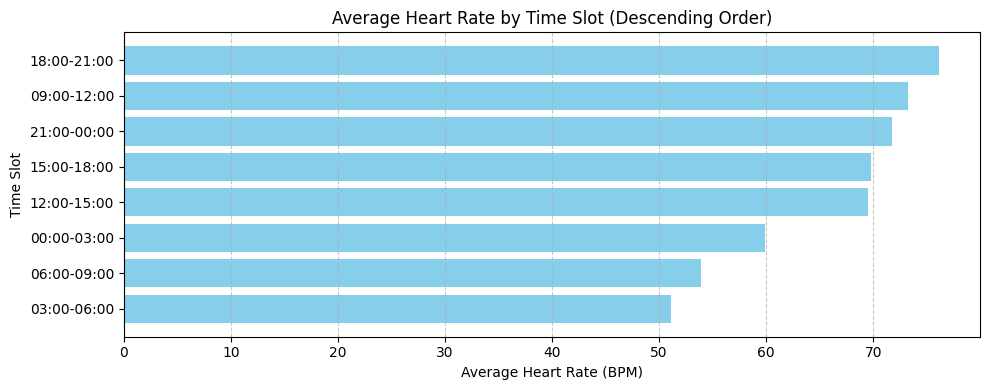

In [81]:
average_heart_rate_by_slot = average_heart_rate_by_slot.sort_values(by='heart_rates', ascending=True)

plt.figure(figsize=(10,4))

plt.barh(average_heart_rate_by_slot["time"], average_heart_rate_by_slot["heart_rates"], color='skyblue')
plt.xlabel("Average Heart Rate (BPM)")
plt.ylabel("Time Slot")
plt.title("Average Heart Rate by Time Slot (Descending Order)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [102]:
min_heart_rate_idx = average_heart_rate_by_slot["heart_rates"].idxmin()
lowest_heart_rate_slot = average_heart_rate_by_slot.loc[min_heart_rate_idx, "time"]

print(f"Time slot with lowest average heart rate: {lowest_heart_rate_slot}")

Time slot with lowest average heart rate: 03:00-06:00


### Analyzing the Relationship Between Lowest Heart Rate Time Slot and Deep Sleep

In this section, we aim to investigate whether the time slot with the lowest average heart rate corresponds to periods of deep sleep.

In [82]:
sleep_data_files = glob.glob("data/raw/sleep/*.csv")
sleep_data_files = [sleep_file.replace("\\", "/") for sleep_file in sleep_data_files]

In [83]:
sleep_dataframes = [
    pd.read_csv(file).assign(date=file.split('/')[-1].replace('.csv', ''))
    for file in sleep_data_files
    if not pd.read_csv(file).empty  # Escludi DataFrame vuoti
]

if sleep_dataframes:
    all_sleep_data = pd.concat(sleep_dataframes, ignore_index=True)
else:
    all_sleep_data = pd.DataFrame()

all_sleep_data.head()

,start_time,end_time,sleep_type,date
0,2024-12-22T01:00:00.0,2024-12-22T01:12:00.0,1.0,2024-12-22
1,2024-12-22T01:12:00.0,2024-12-22T01:57:00.0,0.0,2024-12-22
2,2024-12-22T01:57:00.0,2024-12-22T01:59:00.0,3.0,2024-12-22
3,2024-12-22T01:59:00.0,2024-12-22T02:46:00.0,1.0,2024-12-22
4,2024-12-22T02:46:00.0,2024-12-22T02:55:00.0,0.0,2024-12-22


In [84]:
def convert_to_local_time(timestamp):
    time = pd.to_datetime(timestamp)
    time += pd.Timedelta(hours=1)
    return time.strftime("%H:%M:%S")

all_sleep_data["start_time"] = all_sleep_data["start_time"].apply(convert_to_local_time)
all_sleep_data["end_time"] = all_sleep_data["end_time"].apply(convert_to_local_time)

all_sleep_data.head()

,start_time,end_time,sleep_type,date
0,02:00:00,02:12:00,1.0,2024-12-22
1,02:12:00,02:57:00,0.0,2024-12-22
2,02:57:00,02:59:00,3.0,2024-12-22
3,02:59:00,03:46:00,1.0,2024-12-22
4,03:46:00,03:55:00,0.0,2024-12-22


In [85]:
all_sleep_data.dtypes

start_time     object
end_time       object
sleep_type    float64
date           object
dtype: object

In [86]:
time_slots = {
    "00:00-03:00": (0, 3),
    "03:00-06:00": (3, 6),
    "06:00-09:00": (6, 9),
    "09:00-12:00": (9, 12),
    "12:00-15:00": (12, 15),
    "15:00-18:00": (15, 18),
    "18:00-21:00": (18, 21),
    "21:00-00:00": (21, 24),
}

def split_time_slot(row, time_slots):
    start_time = pd.to_datetime(row['start_time'])
    end_time = pd.to_datetime(row['end_time'])
    intervals = []

    for slot, (start_hour, end_hour) in time_slots.items():
        slot_start = start_time.replace(hour=start_hour, minute=0, second=0, microsecond=0)
        
        if end_hour == 24:
            slot_end = start_time.replace(hour=23, minute=59, second=59, microsecond=0)
        else:
            slot_end = start_time.replace(hour=end_hour, minute=0, second=0, microsecond=0)

        # print(slot_start, slot_end)

        overlap_start = max(start_time, slot_start)
        overlap_end = min(end_time, slot_end) 

        if overlap_start < overlap_end: 
            duration = (overlap_end - overlap_start).total_seconds() / 60
            intervals.append({"time_slot": slot, "duration": duration})

    return intervals

In [87]:
all_sleep_data['split_slots'] = all_sleep_data.apply(lambda row: split_time_slot(row, time_slots), axis=1)

all_sleep_data.head()

,start_time,end_time,sleep_type,date,split_slots
0,02:00:00,02:12:00,1.0,2024-12-22,"[{'time_slot': '00:00-03:00', 'duration': 12.0}]"
1,02:12:00,02:57:00,0.0,2024-12-22,"[{'time_slot': '00:00-03:00', 'duration': 45.0}]"
2,02:57:00,02:59:00,3.0,2024-12-22,"[{'time_slot': '00:00-03:00', 'duration': 2.0}]"
3,02:59:00,03:46:00,1.0,2024-12-22,"[{'time_slot': '00:00-03:00', 'duration': 1.0}..."
4,03:46:00,03:55:00,0.0,2024-12-22,"[{'time_slot': '03:00-06:00', 'duration': 9.0}]"


In [88]:
all_sleep_data = all_sleep_data.explode("split_slots").reset_index(drop=True)
all_sleep_data.head()

,start_time,end_time,sleep_type,date,split_slots
0,02:00:00,02:12:00,1.0,2024-12-22,"{'time_slot': '00:00-03:00', 'duration': 12.0}"
1,02:12:00,02:57:00,0.0,2024-12-22,"{'time_slot': '00:00-03:00', 'duration': 45.0}"
2,02:57:00,02:59:00,3.0,2024-12-22,"{'time_slot': '00:00-03:00', 'duration': 2.0}"
3,02:59:00,03:46:00,1.0,2024-12-22,"{'time_slot': '00:00-03:00', 'duration': 1.0}"
4,02:59:00,03:46:00,1.0,2024-12-22,"{'time_slot': '03:00-06:00', 'duration': 46.0}"


In [91]:
all_sleep_data["time_slot"] = all_sleep_data["split_slots"].apply(lambda x: x["time_slot"] if pd.notnull(x) else None)
all_sleep_data["duration"] = all_sleep_data["split_slots"].apply(lambda x: x["duration"] if pd.notnull(x) else None)

all_sleep_data = all_sleep_data.drop(columns=['split_slots'])
all_sleep_data.head()

,start_time,end_time,sleep_type,date,time_slot,duration
0,02:00:00,02:12:00,1.0,2024-12-22,00:00-03:00,12.0
1,02:12:00,02:57:00,0.0,2024-12-22,00:00-03:00,45.0
2,02:57:00,02:59:00,3.0,2024-12-22,00:00-03:00,2.0
3,02:59:00,03:46:00,1.0,2024-12-22,00:00-03:00,1.0
4,02:59:00,03:46:00,1.0,2024-12-22,03:00-06:00,46.0


In [92]:
output_path = "data/processed/sleep/sleep_data_processed.csv"
all_sleep_data.to_csv(output_path, index=False)

In [93]:
processed_sleep_data = pd.read_csv(output_path)

processed_sleep_data.dtypes

start_time     object
end_time       object
sleep_type    float64
date           object
time_slot      object
duration      float64
dtype: object

In [95]:
sleep_types_by_id = {
    0: "Deep",
    1: "Light",
    2: "Rem",
    3: "Awake"
}

def assign_sleep_type(value):
    return sleep_types_by_id[int(value)]

processed_sleep_data['sleep_mode'] = processed_sleep_data['sleep_type'].apply(assign_sleep_type)
processed_sleep_data.head()

,start_time,end_time,sleep_type,date,time_slot,duration,sleep_mode
0,02:00:00,02:12:00,1.0,2024-12-22,00:00-03:00,12.0,Light
1,02:12:00,02:57:00,0.0,2024-12-22,00:00-03:00,45.0,Deep
2,02:57:00,02:59:00,3.0,2024-12-22,00:00-03:00,2.0,Awake
3,02:59:00,03:46:00,1.0,2024-12-22,00:00-03:00,1.0,Light
4,02:59:00,03:46:00,1.0,2024-12-22,03:00-06:00,46.0,Light


In [103]:
total_deep_sleep = processed_sleep_data.loc[processed_sleep_data["sleep_mode"] == "Deep", "duration"].sum()

deep_sleep_in_lowest_slot = processed_sleep_data.loc[
    (processed_sleep_data["sleep_mode"] == "Deep") & 
    (processed_sleep_data["time_slot"] == lowest_heart_rate_slot), 
    "duration"
].sum()

print("Total Deep Sleep (minutes):", total_deep_sleep)
print("Deep Sleep in Lowest Heart Rate Slot (minutes):", deep_sleep_in_lowest_slot)

Total Deep Sleep (minutes): 1074.0
Deep Sleep in Lowest Heart Rate Slot (minutes): 401.0


In [105]:
deep_sleep_data = processed_sleep_data.loc[processed_sleep_data["sleep_mode"] == "Deep"]

deep_sleep_by_slot = deep_sleep_data.groupby("time_slot")["duration"].sum().reset_index()

deep_sleep_by_slot = deep_sleep_by_slot.sort_values(by='duration', ascending=False)

deep_sleep_by_slot

,time_slot,duration
0,00:00-03:00,460.0
1,03:00-06:00,401.0
3,21:00-00:00,111.0
2,06:00-09:00,102.0


In [109]:
best_slot_by_deep_sleep = deep_sleep_by_slot.iloc[0]["time_slot"]

if best_slot_by_deep_sleep == lowest_heart_rate_slot:
    print("The time slot in which you tend to spend the most deep sleep coincides with the time slot in which you record the lowest average heart rate")
else:
    print("The time slot in which you tend to spend the most deep sleep DOESN'T coincide with the time slot in which you record the lowest average heart rate")

The time slot in which you tend to spend the most deep sleep DOESN'T coincide with the time slot in which you record the lowest average heart rate
